<a href="https://colab.research.google.com/github/yahyakesenek/KOU/blob/master/neuralnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

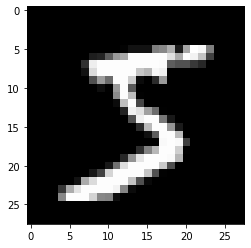

In [4]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as pl

import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

img=x_train[0]
#img = cv2.imread(x_train[0],cv2.IMREAD_GRAYSCALE)/255
pl.imshow(img,cmap="gray")
pl.show()
img.shape

class Conv:
  def __init__(self,num_filters,filter_size):
    self.num_filters=num_filters
    self.filter_size=filter_size
    self.conv_filter=np.random.randn(num_filters,filter_size,filter_size)/(filter_size*filter_size)#(x,4,4)=> 16 ya bölünerek nırmalize edilir.

  def image_region(self,image):#parça üretim amacıyla kullanılmaktadır. n-x+1 patch boyutu
    height,width=image.shape
    self.image = image
    for j in range(height-self.filter_size+1):
      for k in range(width-self.filter_size+1):
        image_patch=image[j:(j+self.filter_size),k:(k+self.filter_size)]
        yield image_patch,j,k
  def forward_prop(self,image):
    height,width=image.shape
    conv_out=np.zeros((height-self.filter_size+1,width-self.filter_size+1,self.num_filters))
    for image_patch,i,j in self.image_region(image):
      conv_out[i,j] = np.sum(image_patch*self.conv_filter,axis=(1,2))
    return conv_out
  def back_prop(self,dl_dout,learning_rate):#dl_dout -> max-pool değeriyle gelecek
    dl=np.zeros(self.conv_filter.shape)
    for image_patch,i,j in self.image_region(self.image):
      for k in range(self.num_filters):
        dl[k] +=image_patch*dl_dout[i,j,k]
    self.conv_filter -=learning_rate*dl
    return dl




(28, 28)
(22, 22, 18)


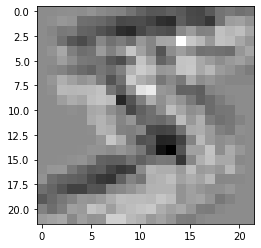

In [5]:
conv = Conv(18,7)
out = conv.forward_prop(img)
print(img.shape)
print(out.shape)
pl.imshow(out[:,:,8],cmap="gray") # 3 değeri 0-17 a kadar değer alabilir
pl.show()

In [0]:
class MaxPool:
  def __init__(self,filter_size):
    self.filter_size=filter_size
  def image_region(self,image):#parça üretim amacıyla kullanılmaktadır. n-x+1 patch boyutu
    height,width=image.shape[0]//self.filter_size,image.shape[1]//self.filter_size
    self.image=image
    for i in range(height-self.filter_size+1):
      for j in range(width-self.filter_size+1):
        image_patch=image[(i*self.filter_size):(i*self.filter_size+self.filter_size),(j*self.filter_size):(j*self.filter_size+self.filter_size)]
        yield image_patch,i,j
    
  def forward_prop(self,image):
    height,width,num_filters=image.shape
    self.num_filters=num_filters
    conv_out=np.zeros((height//self.filter_size,width//self.filter_size,num_filters))
    for image_patch,i,j in self.image_region(image):
      conv_out[i,j] = np.amax(image_patch*self.filter_size,axis=(0,1))
    return conv_out
  def back_prop(self,dl_dout):#softmax kullanımına dikkat edilecek  dl_out bir softmax
    dl=np.zeros(self.image.shape)
    for image_patch,i,j in self.image_region(self.image):
      for k in range(self.num_filters):
        h,w,filter = image_patch.shape
        max_val=np.amax(image_patch,axis=(0,1))
        for i1 in range(h):
          for j1 in range(w):
            for k1 in range(filter):
              if image_patch[i1,j1,k1] == max_val[k1]:
                dl[i*self.filter_size+i1,j*self.filter_size+j1,k1]=dl_dout[j,j,k1]
    
    return dl

(5, 5, 18)


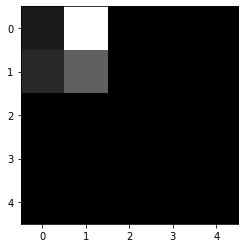

In [7]:
maxpol = MaxPool(4)
out = maxpol.forward_prop(out)
print(out.shape)
pl.imshow(out[:,:,7],cmap="gray")
pl.show()

In [0]:
class Softmax:
  def __init__(self,_input,soft):
    self.weight=np.random.randn(_input,soft)/_input
    self.bias = np.zeros(soft)
  def forward(self,image):
    self.orig_im_shape = image.shape
    flattened = image.flatten()
    self.modified = flattened
    self.out=np.dot(self.modified,self.weight)+self.bias
    exp_out = np.exp(self.out)
    return exp_out/np.sum(exp_out,axis=0)
  def backwad(self,dl_dout,learning_rate):
    for i,grad in enumerate(dl_dout):
      if grad == 0:
        continue
      transformation = np.exp(self.out)
      s_total = np.sum(transformation)
      dy_dz = -transformation[i]*transformation/(s_total**2)#z ye göre türev
      dy_dz[i] = transformation[i]*(s_total-transformation[i])/(s_total**2)

      dz_dw = self.modified
      dz_db = 1
      dz_input = self.weight

      dL_dz=grad*dy_dz
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz*dz_db
      dL_input = dz_input@dL_dz

      self.weight -= learning_rate*dL_dw
      self.bias -=learning_rate*dL_db
      return dL_input.reshape(self.orig_im_shape)



    

In [9]:
s=Softmax(5*5*18,10)
out = s.forward(out)
print(out)

[0.02239518 0.08009746 0.29065291 0.02150349 0.00658305 0.29028761
 0.14689862 0.01673528 0.06277599 0.06207042]


In [0]:
mConv = Conv(8,3) # (28,28,1)=>(26,26,8)
mPool = MaxPool(4) # (26,26,8) => (13,13,8)
mSoftmax = Softmax(6*6*8,10) # (13*13*10) => 10


In [0]:
def forward(img,label):
  out=mConv.forward_prop(img/255)
  out=mPool.forward_prop(out)
  out=mSoftmax.forward(out)

  cross_ent = -np.log(out[label])
  accuracy = 1 if np.argmax(out) == label else 0
  return out,cross_ent,accuracy


In [0]:
def train(img,label,learning_rate=0.005):
  out,loss,acc = forward(img,label)
  grad = np.zeros(10)
  grad[label] = -1/out[label]
  grad_back = mSoftmax.backwad(grad,learning_rate)
  grad_back = mPool.back_prop(grad_back)
  grad_back = mConv.back_prop(grad_back,learning_rate)
  return loss,acc


In [0]:
for epoc in range(10):
  print("Epoch => {}".format(epoc+1))
  loss = 0
  num_correct = 0
  for i,(im,label) in enumerate(zip(x_train,y_train)):
    if i % 100 == 0 and i>0:
      print("{} steps out of 100 steps : average {}  and accuracy {}".format(i+1,loss/100,num_correct))
      loss=0
      num_correct=0
    l1,acc=train(im,label)
    loss+=l1
    num_correct+=acc
    

Epoch => 1
101 steps out of 100 steps : average 2.2654090572298533  and accuracy 14
201 steps out of 100 steps : average 2.2074985548621937  and accuracy 18
301 steps out of 100 steps : average 2.1711532859322182  and accuracy 28
401 steps out of 100 steps : average 2.1127184499663967  and accuracy 32
501 steps out of 100 steps : average 2.056891865135076  and accuracy 35
601 steps out of 100 steps : average 2.0779536987661915  and accuracy 34
701 steps out of 100 steps : average 2.045647493108663  and accuracy 35
801 steps out of 100 steps : average 2.028149610301059  and accuracy 32
901 steps out of 100 steps : average 1.9983590919506329  and accuracy 35
1001 steps out of 100 steps : average 1.9534673693528768  and accuracy 37
1101 steps out of 100 steps : average 1.9690819663798131  and accuracy 41
1201 steps out of 100 steps : average 1.9382714768673417  and accuracy 37
1301 steps out of 100 steps : average 1.8602901822709694  and accuracy 51
1401 steps out of 100 steps : average 1

In [0]:
loss = 0
num_correct = 0
for im,label in zip(x_test,y_test):
  _,l1,acc = forward(im,label)
  loss += l1
  num_correct += acc
num_test = len(x_test)
print("Test loss :",loss/num_test)
print("Test accuracy :",num_correct/num_test)

KeyboardInterrupt: ignored